#FinBERT

In this notebook we try the pre-trained FinBERT model by [Araci, 2019](https://arxiv.org/abs/1908.10063). FinBERT is pre-trained on the TRC2 news dataset from Reuters and the Financial PhraseBank dataset. We download the pre-trained model from the HuggingFace transformers library, [see here](https://huggingface.co/ProsusAI/finbert).
<br></br>
To access the dataset, [see here](https://drive.google.com/file/d/1o1BMTTU9YNPATL8x93l0N-h6sTZxLyDo/view?usp=sharing). 

## Imports

In [ ]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-55w6dua1
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-55w6dua1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 870kB 17.6MB/s 
     |████████████████████████████████| 3.3MB 45.6MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2112159 sha256=98f15ef61a1881f78ad6690c8e21c177dac4f61f11c9c0e56c55260ca5c6a38a
  Stored in directory: /tmp/pip-ephem-wheel-cache-9h_hzfs_/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=1d44131f7763c0a752f693c4c8f54c04c8394669f7fa035e89cc3af7657deddf
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f4483667446543

In [ ]:
#!pip install transformers
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union
import pandas as pd
import numpy as np
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns

import os

from transformers.utils import *
from transformers.data.data_collator import DataCollator, DataCollatorWithPadding, default_data_collator
from transformers.file_utils import (
    WEIGHTS_NAME,
    is_apex_available,
    is_datasets_available,
    is_in_notebook,
    is_sagemaker_dp_enabled,
    is_sagemaker_mp_enabled,
    is_torch_tpu_available,
    is_training_run_on_sagemaker,
)
from transformers.modeling_utils import PreTrainedModel, unwrap_model
from transformers.optimization import Adafactor, AdamW, get_scheduler
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.trainer_callback import (
    CallbackHandler,
    DefaultFlowCallback,
    PrinterCallback,
    ProgressCallback,
    TrainerCallback,
    TrainerControl,
    TrainerState,
)
from transformers.trainer_utils import (
    PREFIX_CHECKPOINT_DIR,
    BestRun,
    EvalPrediction,
    HPSearchBackend,
    PredictionOutput,
    ShardedDDPOption,
    TrainerMemoryTracker,
    TrainOutput,
    default_compute_objective,
    default_hp_space,
    denumpify_detensorize,
    get_last_checkpoint,
    set_seed,
    speed_metrics,
)
from transformers.training_args import ParallelMode, TrainingArguments
from transformers.utils import logging
from transformers.utils.modeling_auto_mapping import MODEL_FOR_QUESTION_ANSWERING_MAPPING_NAMES 
import torch
import tensorflow as tf
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
import tensorflow_hub as hub

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split



from torch.utils.data.dataset import Dataset



## Connecting to cloud hardware

Edit > Notebook Settings > Hardware accelerator

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using CPU')
  device = torch.device("cpu")

There are 1 GPU(s) available
We will use the GPU: Tesla T4


## Importing data

In [ ]:
df = pd.read_csv('/content/final_consolidated_data.txt')
df.head()

,Unnamed: 0,CIK Code,Filing,Date Filed,Ticker,CompanyName,PrevAvgPriceChange,PostAvgPriceChange,Label
0,0,1680378,Investing in ourshares of common stock involve...,2021-03-18,SNES,"SenesTech, Inc.",0.001328,-0.003177,neutral
1,1,1222719,Investing in any of our securities involves ri...,2021-01-31,CHY,CALAMOS CONVERTIBLE & HIGH INCOME FUND,0.004126,0.006552,neutral
2,2,1364954,An investment in our securities involves a hig...,2021-04-03,CHGG,"CHEGG, INC",0.065078,0.011987,neutral
3,3,1674930,Investing in our common stock involves risk. B...,2020-08-12,FLGT,"Fulgent Genetics, Inc.",0.412805,0.058477,neutral
4,4,1409375,Investing in our common stock involves a high ...,2021-03-10,OESX,"ORION ENERGY SYSTEMS, INC.",-0.046603,-0.002521,increase


In [ ]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.dropna(axis = 0, how = 'any', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1350 entries, 0 to 1352
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIK Code            1350 non-null   int64  
 1   Filing              1350 non-null   object 
 2   Date Filed          1350 non-null   object 
 3   Ticker              1350 non-null   object 
 4   CompanyName         1350 non-null   object 
 5   PrevAvgPriceChange  1350 non-null   float64
 6   PostAvgPriceChange  1350 non-null   float64
 7   Label               1350 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 94.9+ KB


## Configuration of parameters

In [ ]:
finbert = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert', cache_dir = None, num_labels = 3)
config = finbert.config

In [ ]:
config.id2label[0] = 'decrease'
config.id2label[1] = 'neutral'
config.id2label[2] = 'increase'
config.id2label

{0: 'decrease', 1: 'neutral', 2: 'increase'}

In [ ]:
config.label2id['decrease'] = 0
config.label2id['neutral'] = 1
config.label2id['increase'] = 2
config.label2id

{'decrease': 0, 'increase': 2, 'negative': 1, 'neutral': 1, 'positive': 0}

In [ ]:
del config.label2id['negative']
del config.label2id['positive']
config.label2id

{'decrease': 0, 'increase': 2, 'neutral': 1}

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

In [ ]:
config.max_position_embeddings = 200
config

BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "decrease",
    "1": "neutral",
    "2": "increase"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "decrease": 0,
    "increase": 2,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 200,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
batch_size = 16
epochs = 5
lr = 2e-5
early_stopping = early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 1,
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)
auto = tf.data.experimental.AUTOTUNE
max_seq_length = 200

## Tokenizing data

In [ ]:
x = df.Filing.values
y = df.Label.values
labs = []

for i in y:
  if i == 'decrease':
    labs.append(0)
  elif i == 'neutral':
    labs.append(1)
  else:
    labs.append(2)
labs = np.array(labs)
x_train, x_test, y_train, y_test = train_test_split(x,labs, test_size = 0.2, random_state = 42)

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(x_train, y_train, test_size =0.2)


In [ ]:
train_encodings = tokenizer(list(train_texts),
                            truncation = True,
                            padding = True,
                            max_length = max_seq_length,
                            return_tensors = 'pt')

val_encodings = tokenizer(list(val_texts),
                          truncation = True,
                          padding = True,
                          max_length = max_seq_length,
                          return_tensors = 'pt')

test_encodings = tokenizer(list(x_test),
                           truncation = True,
                           padding = True,
                           return_tensors = 'pt')

In [ ]:
class SEC_Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = SEC_Dataset(train_encodings, train_labels)
val_dataset = SEC_Dataset(val_encodings, val_labels)
test_dataset = SEC_Dataset(test_encodings, y_test)

## Performance metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def compute_metrics(eval_pred):
  labels = eval_pred.label_ids
  preds = eval_pred.predictions.argmax(-1)
  lab_names = [0,1,2]
  
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average ='weighted')
  acc = accuracy_score(labels, preds)
  print(precision_recall_fscore_support(labels, preds, average = None, labels = lab_names))


  dic = {
      'Accuracy': acc,
      'F1': f1,
      'Precision': precision,
      'Recall': recall
  }
  return dic

## Training

In [ ]:
class MyTrainer(Trainer):
  def __init__(self, model,
        args = None,
        data_collator = None,
        train_dataset = None,
        eval_dataset = None,
        tokenizer = None,
        model_init = None,
        compute_metrics = None,
        callbacks = None,
        optimizers = (None,None)
    ):

    super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init,
                  compute_metrics, callbacks, optimizers) 
    
  def evaluate(
        self,
        train_dataset = None,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
    ) -> Dict[str, float]:
        
        # memory metrics - must set up as early as possible
        self._memory_tracker.start()

        if eval_dataset is not None and not isinstance(eval_dataset, collections.abc.Sized):
            raise ValueError("eval_dataset must implement __len__")

        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        start_time = time.time()

        train_output = self.prediction_loop(
            train_dataloader,
            description = 'Training',
            prediction_loss_only = True if self.compute_metrics is None else None,
            ignore_keys = ignore_keys,
            metric_key_prefix = 'train',
            )


        eval_output = self.prediction_loop(
            eval_dataloader,
            description="Evaluation",
            # No point gathering the predictions if there are no metrics, otherwise we defer to
            # self.args.prediction_loss_only
            prediction_loss_only=True if self.compute_metrics is None else None,
            ignore_keys=ignore_keys,
            metric_key_prefix=metric_key_prefix,
        )
        train_n_samples = len(self.train_dataset)
        train_output.metrics.update(speed_metrics('train', start_time, train_n_samples))
        self.log(train_output.metrics)

        eval_n_samples = len(eval_dataset if eval_dataset is not None else self.eval_dataset)
        eval_output.metrics.update(speed_metrics(metric_key_prefix, start_time, eval_n_samples))
        self.log(eval_output.metrics)

        if self.args.tpu_metrics_debug or self.args.debug:
            # tpu-comment: Logging debug metrics for PyTorch/XLA (compile, execute times, ops, etc.)
            xm.master_print(met.metrics_report())
        
        train_output.metrics['eval_loss'] = 'No log'
        self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, eval_output.metrics)
        self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, train_output.metrics)

        self._memory_tracker.stop_and_update_metrics(train_output.metrics)
        self._memory_tracker.stop_and_update_metrics(eval_output.metrics)

        dic = {
        'Training metrics': train_output.metrics,
        'Validation metrics': eval_output.metrics
        }

        return dic



<b>NOTE:</b>The log prints two rows per epoch because the second row was added into the source code to retrieve the training accuracy. That is why the training loss is the same, and there is no log for validation loss.

In [ ]:
training_args = TrainingArguments(
    output_dir = 'finBERT',
    num_train_epochs = epochs,
    do_train = True,
    do_eval = True,
    evaluation_strategy = 'epoch',
    logging_strategy = 'epoch',
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    warmup_steps = 250,
    weight_decay = 0.01
)

trainer = MyTrainer(
    model = finbert,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.588900,0.837993,0.638889,0.593915,0.638126,0.638889
1,1.588900,No log,0.570602,0.528329,0.663630,0.570602
2,0.879000,0.829581,0.671296,0.665698,0.683340,0.671296
2,0.879000,No log,0.725694,0.712180,0.746601,0.725694
3,0.716200,0.774018,0.708333,0.698501,0.723178,0.708333
3,0.716200,No log,0.813657,0.806940,0.832208,0.813657
4,0.607700,0.655420,0.787037,0.774400,0.792778,0.787037
4,0.607700,No log,0.854167,0.852432,0.868953,0.854167
5,0.534200,0.803667,0.703704,0.703026,0.705088,0.703704
5,0.534200,No log,0.887731,0.886736,0.888294,0.887731


/usr/local/lib/python3.7/dist-packages/transformers/trainer_pt_utils.py:367: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Tranformers.
  FutureWarning,


(array([0.66981132, 0.51683748, 0.92      ]), array([0.26007326, 0.92894737, 0.32701422]), array([0.37467018, 0.66415804, 0.48251748]), array([273, 380, 211]))
(array([0.44      , 0.64739884, 0.83333333]), array([0.22      , 0.92561983, 0.33333333]), array([0.29333333, 0.76190476, 0.47619048]), array([ 50, 121,  45]))
(array([0.69811321, 0.71364653, 0.86868687]), array([0.81318681, 0.83947368, 0.40758294]), array([0.75126904, 0.77146312, 0.55483871]), array([273, 380, 211]))
(array([0.50793651, 0.7421875 , 0.72      ]), array([0.64      , 0.78512397, 0.4       ]), array([0.56637168, 0.76305221, 0.51428571]), array([ 50, 121,  45]))
(array([0.81785714, 0.77173913, 0.95967742]), array([0.83882784, 0.93421053, 0.56398104]), array([0.82820976, 0.8452381 , 0.71044776]), array([273, 380, 211]))
(array([0.55932203, 0.75555556, 0.81818182]), array([0.66      , 0.84297521, 0.4       ]), array([0.60550459, 0.796875  , 0.53731343]), array([ 50, 121,  45]))
(array([0.96396396, 0.78891258, 0.890173

TrainOutput(global_step=270, training_loss=0.865188471476237, metrics={'train_runtime': 244.1086, 'train_samples_per_second': 1.106, 'total_flos': 567567891648000.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 2228011008, 'init_mem_gpu_alloc_delta': 439075328, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 11235328, 'train_mem_gpu_alloc_delta': 1326974464, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 3255743488})

In [ ]:
trainer.state.log_history

[{'epoch': 1.0, 'learning_rate': 1.08e-05, 'loss': 1.5889, 'step': 54},
 {'epoch': 1.0,
  'step': 54,
  'train_Accuracy': 0.5706018518518519,
  'train_F1': 0.5283289417562254,
  'train_Precision': 0.6636304787169279,
  'train_Recall': 0.5706018518518519,
  'train_loss': 0.916656494140625,
  'train_runtime': 13.869,
  'train_samples_per_second': 62.297},
 {'epoch': 1.0,
  'eval_Accuracy': 0.6388888888888888,
  'eval_F1': 0.5939153439153438,
  'eval_Precision': 0.6381262042389211,
  'eval_Recall': 0.6388888888888888,
  'eval_loss': 0.8379929661750793,
  'eval_runtime': 13.8704,
  'eval_samples_per_second': 15.573,
  'step': 54},
 {'epoch': 2.0, 'learning_rate': 2.16e-05, 'loss': 0.879, 'step': 108},
 {'epoch': 2.0,
  'step': 108,
  'train_Accuracy': 0.7256944444444444,
  'train_F1': 0.7121798610325983,
  'train_Precision': 0.7466012931480656,
  'train_Recall': 0.7256944444444444,
  'train_loss': 0.7005714178085327,
  'train_runtime': 13.2764,
  'train_samples_per_second': 65.078},
 {'epo

## Plotting training

In [ ]:
for log_history in trainer.state.log_history:
  print(log_history.keys())

dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall', 'eval_runtime', 'eval_samples_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall', 'eval_runtime', 'eval_samples_per_second', 'epoch', 'step'])
dict_keys(['loss', 'learning_rate', 'epoch', 'step'])
dict_keys(['train_loss', 'train_Accuracy', 'train_F1', 'train_Precision', 'train_Recall', 'train_runtime', 'train_samples_per_second', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall', 'e

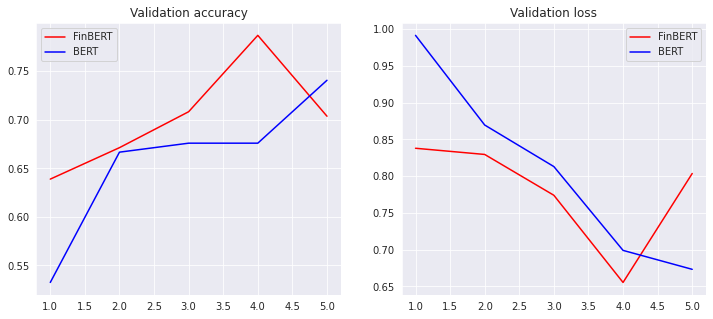

In [ ]:
# here we plot BERT vs finBERT
finbert_train_loss = []
finbert_val_loss = []
finbert_train_acc = []
finbert_val_acc = []
bert_val_loss = [0.9916209578514099, 0.8696171641349792, 0.8130695223808289, 0.6990460753440857, 0.6732652187347412]
bert_acc = [0.5324074074074074, 0.6666666666666666, 0.6759259259259259, 0.6759259259259259, 0.7407407407407407]


for log_history in trainer.state.log_history:

  if 'train_loss' in log_history.keys():
    # Deal with trianing loss.
    finbert_train_loss.append(log_history['train_loss'])
    finbert_train_acc.append(log_history['train_Accuracy'])
    
  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    finbert_val_loss.append(log_history['eval_loss'])
    finbert_val_acc.append(log_history['eval_Accuracy'])

sns.set_style('darkgrid')

x = range(1, len(finbert_train_acc) + 1)
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(x, finbert_val_acc, 'r', label = 'FinBERT')
plt.plot(x, bert_acc, 'b', label = 'BERT')
plt.title('Validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(x, finbert_val_loss, 'r', label = 'FinBERT')
plt.plot(x, bert_val_loss, 'b', label = 'BERT')
plt.title('Validation loss')
plt.legend()

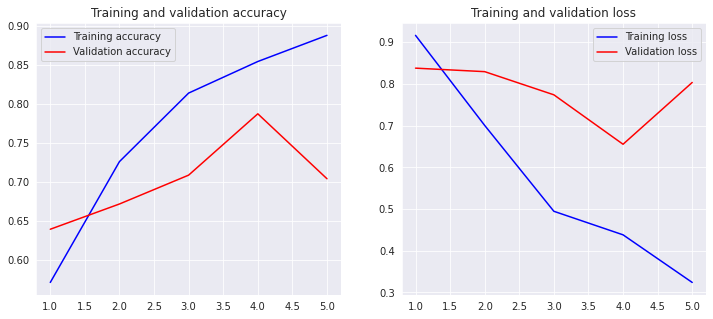

In [ ]:
# here we plot finBERT training
x = range(1, len(finbert_train_acc) + 1)
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(x, finbert_train_acc, 'b', label = 'Training accuracy')
plt.plot(x, finbert_val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(x, finbert_train_loss, 'b', label = 'Training loss')
plt.plot(x, finbert_val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()